In [1]:
import pathlib

import json
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
def get_angles(file, sigma=5):
    with open(file) as f:
        data = json.load(f)['wellPoissMouv'][0][0][0]

    xy = np.stack([data['TailX_VideoReferential'],
                   data['TailY_VideoReferential']], axis=-1)
    
    filtered = gaussian_filter(xy, sigma=[0, sigma, 0], mode='nearest')
    diff = filtered[:, :-1] - filtered[:, 1:]
    heading = data['Heading'][0]
    heading_vector = np.array([np.cos(heading), np.sin(heading)])
    angles = np.arctan2(np.cross(diff, heading_vector), np.dot(diff, heading_vector))
    
    return angles


def to_points(components, scale, mean, strength):
    eigentails = components * strength * scale + mean
    return np.cumsum(np.stack([np.sin(eigentails), np.cos(eigentails)], axis=-1), axis=1)

# Data

In [3]:
results = list(pathlib.Path('data').glob('*'))
for result in results:
    print(result.as_posix())

data/results_F2-set1-T1_0.txt
data/results_F2-set1-T2_10L.txt
data/results_F2-set1-T3_10R.txt
data/results_F2-set1-T4_10R.txt
data/results_F2-set1-T5_10L.txt
data/results_F2-set1-T6_0.txt
data/results_F2-set2-T1_0.txt
data/results_F2-set2-T2_10L.txt
data/results_F2-set2-T3_10R.txt
data/results_F2-set2-T4_10R.txt
data/results_F2-set2-T5_10L.txt
data/results_F2-set2-T6_0.txt


# Extract angles

In [4]:
angles = np.concatenate([get_angles(result) for result in results], axis=0)

# PCA

In [5]:
n_components = 3

pipeline = make_pipeline(StandardScaler(), PCA(n_components)) # Normalize data
pipeline.fit(angles)

z = pipeline.transform(angles)
components = pipeline.steps[1][-1].components_
mean = pipeline.steps[0][-1].mean_
scale = pipeline.steps[0][-1].scale_

# Visualization

In [6]:
max_coef = 60
n_lines = 100
cmap = 'gray_r'

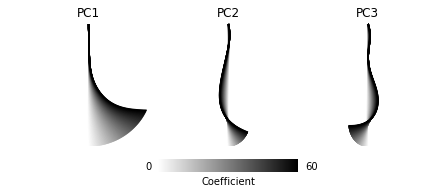

In [7]:
# Parameters
max_coef = 60
n_lines = 100
cmap = cm.gray_r
subplot_size = 2.5
height_ratios = [1, .1]


# Plotting
linspace = np.linspace(0, 1, n_lines)
lines = np.array([[to_points(components, scale, mean, i * max_coef)[k]
                   for i in linspace] for k in range(n_components)])

xmax = max(abs(lines[..., 0].max()), abs(lines[..., 0].min()))
ymax = abs(lines[..., 1].max())
vmax = max(xmax, ymax / 2)

fig = plt.figure(constrained_layout=False,
                 figsize=(subplot_size * n_components,
                          subplot_size * sum(height_ratios)))

spec = gridspec.GridSpec(ncols=n_components, nrows=2, figure=fig, height_ratios=height_ratios)
axes = [fig.add_subplot(spec[0, i]) for i in range(n_components)]

for k in range(n_components):
    ax = axes[k]
    
    for i, val in enumerate(linspace):
        ax.plot(*lines[k, i].T, color=cmap(val))
    
    ax.axis('off')
    ax.set_aspect('equal', 'box')
    ax.set_xlim([-vmax, vmax])
    ax.set_ylim([0, 2 * vmax])
    ax.set_title(f'PC{k+1}')
    ax.invert_yaxis()

cbar_ax = fig.add_subplot(spec[1, 1])
cbar_ax.text(-.05, 0.5, 0, transform=cbar_ax.transAxes, ha='right', va='center')
cbar_ax.text(1.05, 0.5, max_coef, transform=cbar_ax.transAxes, ha='left', va='center')

cb = colorbar.ColorbarBase(cbar_ax, cmap=cmap, orientation='horizontal',
                           norm=colors.Normalize(vmin=0, vmax=max_coef))
cb.set_label('Coefficient')
cb.set_ticks([])
cb.outline.set_visible(False)

fig.subplots_adjust(wspace=0)